# Collaborative Filtering Recommender System

## Part 1: Importing the data

In [1]:
import gzip
import json
import pandas as pd

## IF AN ERROR IS ENCOUNTERED PLEASE DOUBLE CHECK THAT THE FILE IS IN THE "DATA" FOLDER
filename="data/goodreads_reviews_poetry_cleaned.json.gz"

with gzip.GzipFile(filename, 'r',) as fin:
    data=[]
    for line in fin:
        info=json.loads(line.decode('utf-8'))
        new_info={}
        new_info['user_id']=info['user_id']
        new_info['book_id']=info['book_id']
        new_info['rating']=info['rating']
        new_info['date']=info['date']
        data.append(new_info)

In [2]:
data[0]

{'user_id': '3ca7375dba942a760e53b726c472a7dd',
 'book_id': '402128',
 'rating': 5,
 'date': 'Fri Jun 15 11:41:12 -0700 2012'}

In [3]:
data[0]['date']

'Fri Jun 15 11:41:12 -0700 2012'

## Part 2: Data exploration

Build histogram that shows how many users have between 0-5 ratings, 6-10 ratings, etc

In [4]:
import matplotlib.pyplot as plt
import numpy as np

user_to_num_ratings={}
for rating in data: 
    if rating['user_id'] not in user_to_num_ratings:
        user_to_num_ratings[rating['user_id']]=1
    else:
        user_to_num_ratings[rating['user_id']]+=1

In [5]:
len(user_to_num_ratings)

36636

In [6]:
counts=[]
for user in user_to_num_ratings:
    counts.append(user_to_num_ratings[user])
counts=np.array(counts)

Text(0, 0.5, 'Number of users')

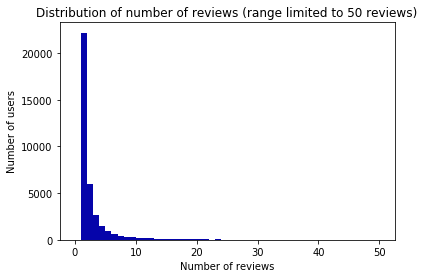

In [7]:
n, bins, patches = plt.hist(x=counts, bins=50, range=(0,50), color='#0504aa')
plt.title('Distribution of number of reviews (range limited to 50 reviews)')
plt.xlabel('Number of reviews')
plt.ylabel('Number of users')

Text(0, 0.5, 'Number of users')

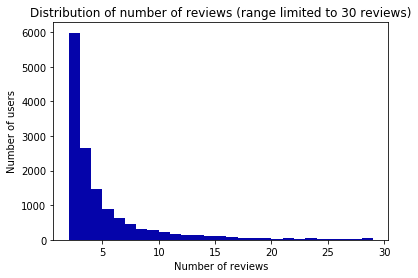

In [8]:
n, bins, patches = plt.hist(x=counts, bins=[i for i in range(2,30)], range=(2,30), color='#0504aa')
plt.title('Distribution of number of reviews (range limited to 30 reviews)')
plt.xlabel('Number of reviews')
plt.ylabel('Number of users')

In [9]:
max(counts)

1062

## Part 3: Determine the bins for number of reviews

Figure out how to divide the data so that we have a few well-populated bins that differentiate users by how many books they've rated

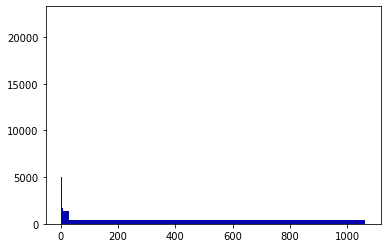

In [10]:
n, bins, patches = plt.hist(x=counts, bins=[1,2,3,6,10,30,1062], color='#0504aa')

In [11]:
print(n)
print(n/sum(n))

[22173.  5984.  5012.  1701.  1398.   368.]
[0.60522437 0.16333661 0.13680533 0.04642974 0.03815919 0.01004476]


... and then visualize the results in a pie chart and bar chart to see the breakdown more clearly!

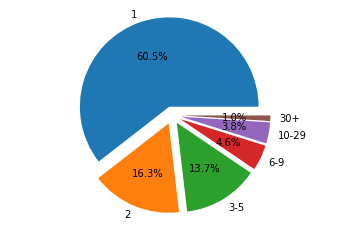

In [12]:
labels=["1","2","3-5","6-9","10-29","30+"]
sizes=n/sum(n)
fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=[0.1 for i in range(6)],labels=labels, autopct='%1.1f%%')
ax1.axis('equal') 
plt.show()


Text(0, 0.5, 'Number of users')

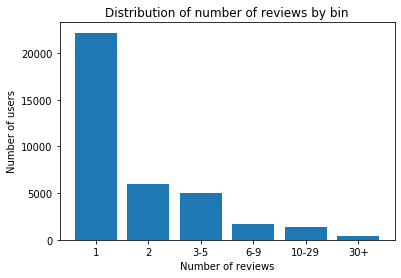

In [14]:
plt.bar(labels,n)
plt.title('Distribution of number of reviews by bin')
plt.xlabel('Number of reviews')
plt.ylabel('Number of users')

## Part 4: Set up data structures for later separation into training and testing sets

First, we built a helper function that can help interpret a date string of the form 'Fri Jun 15 11:41:12 -0700 2012' as seen in part 1.1. By transforming this date into a number of the form YYYYMMDD, we can easily sort by date

In [15]:
def interpret_date_string(date_string):
    split=date_string.split(' ')
    output_str=split[-1]
    month_to_num={"Jan":"01","Feb":"02","Mar":"03","Apr":"04","May":"05","Jun":"06","Jul":"07",
                 "Aug":"08","Sep":"09","Oct":"10","Nov":"11","Dec":"12"}
    output_str=output_str+month_to_num[split[1]]+split[2]
    return int(output_str)

Next, we build a dictionary that contains user info. This data would end up being of the form: 

{ user_id : \[ (date1, bookId1, rating1), (date2, bookId2, rating2), ...\] }

In [16]:
user_info={}
for rating in data:
    if rating['user_id'] not in user_info:
        user_info[rating['user_id']]=[]
    user_info[rating['user_id']].append((interpret_date_string(rating['date']),rating['book_id'],rating['rating']))

Just a quick check to see that the data looks as expected.

In [17]:
c=0
for user in user_info:
    print(user,user_info[user])
    c+=1
    if c==10:
        break

3ca7375dba942a760e53b726c472a7dd [(20120615, '402128', 5)]
0ef32090550901ead25cb0ea21c4d36b [(20140414, '92270', 5)]
d37b46b2190ed7c518259f29b47a9b36 [(20170930, '253264', 5)]
f4c6fe33ef61c38f7f4aeb5224c259a5 [(20130507, '13105527', 5)]
4672eb229c808b792b8ea95f01f19784 [(20141011, '1420', 1), (20160113, '1381', 3)]
b54c83f02c748fe75ed309e1e12eace2 [(20121014, '15787122', 3)]
f88032f4ad97b46654fe59ce3387cf5d [(20151017, '23668465', 4), (20140323, '18600808', 0), (20141230, '18745066', 4), (20131217, '1215884', 3), (20160217, '18141482', 5), (20130702, '3049', 2)]
f2f95653b98e1a4a68c3beab1a7f8f5e [(20160330, '704880', 5)]
7e4945a6266566e39e3f251fff0fdde1 [(20140912, '128436', 5)]
6665fe2d574221577f8a5483a6f17844 [(20160225, '11958313', 5)]


## Part 5: Separate the training and testing sets

For users with 2-5 ratings, only the last review goes into the testing set. 

For users with > 5 ratings, the most recent floor(0.2 * total_number_of_reviews) reviews go into the testing set.

Create two dictionaries, one representing the training set and one representing the testing set.

Categories of number of ratings: "2","3-5","6-9","10-29","30+", as determined by previous exploration

In [18]:
training={"book_ids":[],"user_ids":[],"ratings":[]}
testing={"2":[],"3-5":[],"6-9":[],"10-29":[],"30+":[]}
for user in user_info:
    l=len(user_info[user])
    user_info[user].sort()
    if l==2:
        training["book_ids"].append(user_info[user][0][1])
        training["user_ids"].append(user)
        training["ratings"].append(user_info[user][0][2])
        testing["2"].append([user,user_info[user][1][1],user_info[user][1][2]])
    elif 3<=l<=5:
        for i in range(l-1):
            training["book_ids"].append(user_info[user][i][1])
            training["user_ids"].append(user)
            training["ratings"].append(user_info[user][i][2])
        testing["3-5"].append([user,user_info[user][l-1][1],user_info[user][l-1][2]])
    elif l>5:
        cutoff=int(0.8*l)
        for i in range(cutoff):
            training["book_ids"].append(user_info[user][i][1])
            training["user_ids"].append(user)
            training["ratings"].append(user_info[user][i][2])    
        if l<=9:
            for i in range(cutoff,l):
                testing["6-9"].append([user,user_info[user][i][1],user_info[user][i][2]])
        elif l<=29:
            for i in range(cutoff,l):
                testing["10-29"].append([user,user_info[user][i][1],user_info[user][i][2]])
        else:
            for i in range(cutoff,l):
                testing["30+"].append([user,user_info[user][i][1],user_info[user][i][2]])

## Part 6: Set up and train KNN model using Surprise

Documentation for this package: http://surpriselib.com/

In [19]:
import surprise as sp

df = pd.DataFrame(training)
reader = sp.Reader(rating_scale=(1, 5))

# Loads Pandas dataframe
data = sp.Dataset.load_from_df(df[["user_ids", "book_ids", "ratings"]], reader)

sim_options = {"name": "cosine","user_based": True}
algo = sp.KNNWithMeans(sim_options=sim_options)

trainingSet = data.build_full_trainset()

algo.fit(trainingSet)


Computing the cosine similarity matrix...


C:\Users\amand\AppData\Local\Continuum\anaconda3\lib\site-packages\surprise\prediction_algorithms\algo_base.py:249: RuntimeWarning: invalid value encountered in double_scalars
  sim = construction_func[name](*args)


Done computing similarity matrix.


## Part 7: Use Case 1: Testing the algorithm on specific users and books of your choosing

First, find some users we can test the algorithm on. Then see what this algorithm predicts vs what the user actually rated the book.

In [20]:
c=0
for user in user_info:
    if len(user_info[user])>5:
        print(user,user_info[user],'\n')
        c+=1
    if c==10:
        break

f88032f4ad97b46654fe59ce3387cf5d [(20130702, '3049', 2), (20131217, '1215884', 3), (20140323, '18600808', 0), (20141230, '18745066', 4), (20151017, '23668465', 4), (20160217, '18141482', 5)] 

5f550cc8d90df1759eda1496621187d8 [(20120605, '77760', 5), (20140226, '143505', 2), (20140226, '15997', 4), (20140919, '11737010', 4), (20160531, '20821025', 4), (20161108, '24925181', 3), (20161121, '20613761', 3)] 

d1e368a7d2870eb6fbf6e0d350568a2d [(20100709, '3873511', 2), (20111205, '10339809', 5), (20120319, '397743', 2), (20120705, '14361553', 5), (20140326, '7014471', 2), (20140712, '1577264', 3), (20141005, '20143862', 3), (20141104, '18166919', 3), (20150105, '20708745', 2), (20150115, '17243953', 3), (20150121, '14950010', 4), (20170118, '25066584', 3), (20170215, '9630712', 4), (20170227, '29102892', 3), (20170609, '30320055', 3)] 

f1be68e7aec2297644ee1fefe40b933d [(20081019, '699676', 5), (20090126, '195136', 4), (20090307, '104090', 3), (20090510, '102331', 2), (20110910, '593236', 

In [31]:
# Can choose these values from the above lists (just check that the book chosen is not in the training set)
user_id_to_predict='13a8074a4cf64337edcf084b30b9a72a'
book_id_to_predict='1505014'

prediction = algo.predict(user_id_to_predict,book_id_to_predict)
print('Model\'s prediction: ',prediction.est)

# Find actual rating for the book
user_to_predict_num_ratings=len(user_info[user_id_to_predict])
actual_rating_for_prediction=None
for i in range(user_to_predict_num_ratings):
    if user_info[user_id_to_predict][user_to_predict_num_ratings-i-1][1]==book_id_to_predict:
        actual_rating_for_prediction=user_info[user_id_to_predict][user_to_predict_num_ratings-i-1][2]
if actual_rating_for_prediction:
    print('Actual Rating:',actual_rating_for_prediction)
else:
    print('User did not rate this book, so we do not know how accurate/inaccurate the prediction is.')


Model's prediction:  3.9642857142857144
Actual Rating: 4


## Part 8: Use Case 2: Examining algorithm results on users of your choosing

Next, let's import the book data file so we can obtain the actual book names.

In [88]:
## IF AN ERROR IS ENCOUNTERED PLEASE DOUBLE CHECK THAT THE FILE IS IN THE "DATA" FOLDER
books = pd.read_json("data/goodreads_books_poetry.json", lines = True)
books.head()

,isbn,text_reviews_count,series,country_code,language_code,popular_shelves,asin,is_ebook,average_rating,kindle_asin,...,publication_month,edition_information,publication_year,url,image_url,book_id,ratings_count,work_id,title,title_without_series
0,,1,[],US,eng,"[{'count': '8', 'name': 'to-read'}, {'count': ...",,false,3.83,,...,11,,1887,https://www.goodreads.com/book/show/16037549-v...,https://images.gr-assets.com/books/1348176637m...,16037549,3,5212748,Vision of Sir Launfal and Other Poems,Vision of Sir Launfal and Other Poems
1,0811223981,2,[],US,,"[{'count': '100', 'name': 'to-read'}, {'count'...",,false,3.83,B00U2WY9U8,...,4,,2015,https://www.goodreads.com/book/show/22466716-f...,https://images.gr-assets.com/books/1404958407m...,22466716,37,41905435,Fairy Tales: Dramolettes,Fairy Tales: Dramolettes
2,0374428115,7,[],US,,"[{'count': '32', 'name': 'to-read'}, {'count':...",,false,4.38,,...,7,,2008,https://www.goodreads.com/book/show/926662.Gro...,https://s.gr-assets.com/assets/nophoto/book/11...,926662,45,911665,Growltiger's Last Stand and Other Poems,Growltiger's Last Stand and Other Poems
3,0156182890,12,[],US,,"[{'count': '554', 'name': 'to-read'}, {'count'...",,false,3.71,B00IWTRB1W,...,3,,1964,https://www.goodreads.com/book/show/926667.The...,https://images.gr-assets.com/books/1382939971m...,926667,115,995066,The Cocktail Party,The Cocktail Party
4,1942004192,4,[],US,eng,"[{'count': '228', 'name': 'to-read'}, {'count'...",,false,5.00,,...,12,First,2015,https://www.goodreads.com/book/show/29065952-l...,https://images.gr-assets.com/books/1455198396m...,29065952,9,49294781,Louder Than Everything You Love,Louder Than Everything You Love


There's a lot of information here, but we can see that we don't need most of it. Create new data structure that only contains book ids and their titles.

In [89]:
# Restructure the data to map from book_id to title
book_id_to_title={}
for index, row in books.iterrows():
    book_id_to_title[str(row['book_id'])]=row['title']

Construct a list of sample user ids, specifically for users with between 5 and 15 (inclusive) reviews. This is simply for easier readability and absorption (we don't want to see a list of 50 book ratings or a list of just 2 ratings). 

In [90]:
sample_user_ids=[]
for user in user_info:
    if 15>=len(user_info[user])>=5:
        sample_user_ids.append(user)

In [91]:
len(sample_user_ids)

3476

In the next section, you can select a number that is within the range \[0,len(sample_user_ids)\] (which is shown above for ease of use). This number will represent the selected user at that index. The code will show you the ratings for books in the training set for that user, as well as the model's predictions and the actual ratings for books in their test set.

In [92]:
# PASS IN A NUMBER BETWEEN 0 and 3475 INCLUSIVE
INDEX = 400

if 0<=INDEX<=len(sample_user_ids)-1 and type(INDEX)==int:
    user_id_to_predict=sample_user_ids[INDEX]
    num_reviews=len(user_info[user_id_to_predict])

    num_testing=num_reviews//5
    num_training=num_reviews-num_testing
    print('The selected user with user id \"'+user_id_to_predict+'\" had the following ratings:')
    reviews_list=sorted(user_info[user_id_to_predict])

    for i in range(num_training):
        print(book_id_to_title[reviews_list[i][1]]+',','Rating',reviews_list[i][2])

    print()
    print('For the test set, these are the predicted ratings vs actual ratings')
    for i in range(num_testing):
        print(book_id_to_title[reviews_list[num_reviews-i-1][1]]+',','Rating',str(reviews_list[num_reviews-i-1][2])+',','Predicted Rating',round(algo.predict(user_id_to_predict,str(reviews_list[num_reviews-i-1][1])).est,2))
else:
    print('Invalid index. Please input an integer between 0 and',len(sample_user_ids)-1)

The selected user with user id "0a7276734fc830ec552206cc833c42e0" had the following ratings:
The Princess Saves Herself in this One, Rating 5
It Starts Like This: A Collection of Poetry, Rating 4
The Dogs I Have Kissed, Rating 5
love, and you, Rating 5
hummingbird, Rating 4

For the test set, these are the predicted ratings vs actual ratings
The Sun and Her Flowers, Rating 4, Predicted Rating 4.19


## Part 9: Evaluation: Calculating error metrics for model overall, separated by number of ratings 

The primary reason for dividing these error metrics by bin is so we can see how the model results compare as we know more about each user

In [36]:
for category in ["2","3-5","6-9","10-29","30+"]:
    tp,tn,fp,fn=0,0,0,0 # True positive, true negative, false positive, false negative
    for userid,bookid,bookrating in testing[category]: # list of lists of userid,bookid,rating
        prediction = algo.predict(userid,bookid)
        if prediction.est>=3.5:
            if bookrating>3.5:
                tp+=1
            else:
                fp+=1
        else:
            if bookrating>3.5:
                fn+=1
            else:
                tn+=1
    print("Category of users who rated "+category+" poetry books.")
    if tp+fp!=0:
        print("Precision:",str(tp/(tp+fp)))
    if tp+fn!=0:
        print("Recall:",str(tp/(tp+fn)))
    if tp+0.5*(fp+fn)!=0:
        print("F1 score:",str(tp/(tp+0.5*(fp+fn))))
    print()
    print("True positives:",tp)
    print("True negatives:",tn)
    print("False positives:",fp)
    print("False negatives:",fn)
    print("------------------------------------------------")

Category of users who rated 2 poetry books.
Precision: 0.7597066436583262
Recall: 0.8221288515406162
F1 score: 0.7896860986547085

True positives: 3522
True negatives: 586
False positives: 1114
False negatives: 762
------------------------------------------------
Category of users who rated 3-5 poetry books.
Precision: 0.7550761421319797
Recall: 0.8399209486166008
F1 score: 0.7952419139267576

True positives: 2975
True negatives: 505
False positives: 965
False negatives: 567
------------------------------------------------
Category of users who rated 6-9 poetry books.
Precision: 0.7502807937102209
Recall: 0.8459265512874631
F1 score: 0.7952380952380952

True positives: 2004
True negatives: 366
False positives: 667
False negatives: 365
------------------------------------------------
Category of users who rated 10-29 poetry books.
Precision: 0.7719115734720416
Recall: 0.8558246828143022
F1 score: 0.8117051825516204

True positives: 2968
True negatives: 454
False positives: 877
False neg

## Part 10: Trying other variations of KNN models

Repeat steps 6 + 8 using other parameters and variations of the KNN model

In [42]:
for model_var in [sp.KNNWithMeans,sp.KNNWithZScore,sp.KNNBaseline]:
    for sim_name in ['cosine','msd','pearson','pearson_baseline']:
        print("MODEL DETAILS:",str(model_var)[44:-2],'using',sim_name,'similarity')
        ###################### STEP 6 #########################

        df = pd.DataFrame(training)
        reader = sp.Reader(rating_scale=(1, 5))

        # Loads Pandas dataframe
        data = sp.Dataset.load_from_df(df[["user_ids", "book_ids", "ratings"]], reader)

        sim_options = {"name": sim_name,"user_based": True}
        algo = model_var(sim_options=sim_options,verbose=False)

        trainingSet = data.build_full_trainset()

        algo.fit(trainingSet)

        ####################### STEP 8 variation ########################
        # Because there will be a lot of things being printed, only overall stats are shown
        
        tp,tn,fp,fn=0,0,0,0 # True positive, true negative, false positive, false negative
        for category in ["2","3-5","6-9","10-29","30+"]:
            for userid,bookid,bookrating in testing[category]: # list of lists of userid,bookid,rating
                prediction = algo.predict(userid,bookid)
                if prediction.est>=3.5:
                    if bookrating>3.5:
                        tp+=1
                    else:
                        fp+=1
                else:
                    if bookrating>3.5:
                        fn+=1
                    else:
                        tn+=1
        if tp+fp!=0:
            print("Precision:",str(tp/(tp+fp)))
        if tp+fn!=0:
            print("Recall:",str(tp/(tp+fn)))
        if tp+0.5*(fp+fn)!=0:
            print("F1 score:",str(tp/(tp+0.5*(fp+fn))))
        print()
        print("True positives:",tp)
        print("True negatives:",tn)
        print("False positives:",fp)
        print("False negatives:",fn)
        print("---------------------------------------------------------")


MODEL DETAILS: KNNWithMeans using cosine similarity
Precision: 0.7615904447587616
Recall: 0.843369300382875
F1 score: 0.8003963993723676

True positives: 14538
True negatives: 2326
False positives: 4551
False negatives: 2700
---------------------------------------------------------
MODEL DETAILS: KNNWithMeans using msd similarity
Precision: 0.7616053651891439
Recall: 0.8432532776424179
F1 score: 0.8003523840986676

True positives: 14536
True negatives: 2327
False positives: 4550
False negatives: 2702
---------------------------------------------------------
MODEL DETAILS: KNNWithMeans using pearson similarity
Precision: 0.757287024230316
Recall: 0.8575820860888734
F1 score: 0.8043200304687288

True positives: 14783
True negatives: 2139
False positives: 4738
False negatives: 2455
---------------------------------------------------------
MODEL DETAILS: KNNWithMeans using pearson_baseline similarity
Precision: 0.7582213987957388
Recall: 0.8546815175774451
F1 score: 0.8035670457334533

Tru

We can see that the F1 scores are the highest for the KNN Baseline mode, but there is a notable imbalance between the number of false negatives and false positives. 

## Part 11: Trying some matrix factorization based algorithms

In [46]:
for model_var in [sp.SVD,sp.SVDpp]:
    for num_epochs in [10,20,30,50,100]:
        print("MODEL DETAILS:",str(model_var)[60:-2],'using',num_epochs,'epochs')
        ###################### STEP 6 #########################

        df = pd.DataFrame(training)
        reader = sp.Reader(rating_scale=(1, 5))

        # Loads Pandas dataframe
        data = sp.Dataset.load_from_df(df[["user_ids", "book_ids", "ratings"]], reader)

        algo = model_var(n_epochs=num_epochs)

        trainingSet = data.build_full_trainset()

        algo.fit(trainingSet)

        ####################### STEP 8 variation ########################
        # Because there will be a lot of things being printed, only overall stats are shown
        
        tp,tn,fp,fn=0,0,0,0 # True positive, true negative, false positive, false negative
        for category in ["2","3-5","6-9","10-29","30+"]:
            for userid,bookid,bookrating in testing[category]: # list of lists of userid,bookid,rating
                prediction = algo.predict(userid,bookid)
                if prediction.est>=3.5:
                    if bookrating>3.5:
                        tp+=1
                    else:
                        fp+=1
                else:
                    if bookrating>3.5:
                        fn+=1
                    else:
                        tn+=1
        if tp+fp!=0:
            print("Precision:",str(tp/(tp+fp)))
        if tp+fn!=0:
            print("Recall:",str(tp/(tp+fn)))
        if tp+0.5*(fp+fn)!=0:
            print("F1 score:",str(tp/(tp+0.5*(fp+fn))))
        print()
        print("True positives:",tp)
        print("True negatives:",tn)
        print("False positives:",fp)
        print("False negatives:",fn)
        print("---------------------------------------------------------")
        


MODEL DETAILS: SVD using 10 epochs
Precision: 0.7433789954337899
Recall: 0.9444251073210349
F1 score: 0.8319280494659921

True positives: 16280
True negatives: 1257
False positives: 5620
False negatives: 958
---------------------------------------------------------
MODEL DETAILS: SVD using 20 epochs
Precision: 0.7551626659000527
Recall: 0.9143172061724097
F1 score: 0.8271536907292241

True positives: 15761
True negatives: 1767
False positives: 5110
False negatives: 1477
---------------------------------------------------------
MODEL DETAILS: SVD using 30 epochs
Precision: 0.7596007277376211
Recall: 0.896159647290869
F1 score: 0.8222488356620093

True positives: 15448
True negatives: 1988
False positives: 4889
False negatives: 1790
---------------------------------------------------------
MODEL DETAILS: SVD using 50 epochs
Precision: 0.7644204034174208
Recall: 0.8771899292261284
F1 score: 0.816931845808909

True positives: 15121
True negatives: 2217
False positives: 4660
False negatives